## Visual insights into Passwords: Part 2

### Objective
In part 1, we took a look the dataset, and had a few visualizations. Next, we want to conduct topic modelling from a machine learning point of view. More specifically, we will employ a [fastText embedding](https://en.wikipedia.org/wiki/FastText) to represent passwords as 300-dimensional vectors. To visualize them in 2 or 3 dimensions, we will use dimension reduction techniques. 

In [46]:
# import the necessary libraries
import pandas as pd
import numpy as np
import gensim
from gensim.models import fasttext
import matplotlib
import matplotlib.pyplot as plt
import PyQt5
import umap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
%matplotlib qt

In [2]:
df = pd.read_csv('../data/data2use/USA2/data0.csv', index_col=0)
df.head(10)

,password,frequency,distance_score,passlength,unique_c,first_char,last_char,number_of_uppercase,number_of_digits,number_of_symbols,number_of_lowercase,category,zxcvbn
0,123456,67329,1.00,6,6,digit,digit,0,6,0,0,numeric,0
1,123456789,25745,1.00,9,9,digit,digit,0,9,0,0,numeric,0
2,qwerty,25539,1.00,6,6,lower,lower,0,0,0,6,alphabetic,0
3,password,11259,3.50,8,7,lower,lower,0,0,0,8,alphabetic,0
4,12345,9922,1.00,5,5,digit,digit,0,5,0,0,numeric,0
5,b123456,9150,1.54,7,7,lower,digit,0,6,0,1,numeric,1
6,123456b,9143,1.43,7,7,digit,lower,0,6,0,1,numeric,1
7,123456c,8251,1.67,7,7,digit,lower,0,6,0,1,numeric,1
8,c123456,8244,1.36,7,7,lower,digit,0,6,0,1,numeric,1
9,12345678,8088,1.00,8,8,digit,digit,0,8,0,0,numeric,0


In [35]:
df.iloc[:100000,:]

,password,frequency,distance_score,passlength,unique_c,first_char,last_char,number_of_uppercase,number_of_digits,number_of_symbols,number_of_lowercase,category,zxcvbn
0,123456,67329,1.00,6,6,digit,digit,0,6,0,0,numeric,0
1,123456789,25745,1.00,9,9,digit,digit,0,9,0,0,numeric,0
2,qwerty,25539,1.00,6,6,lower,lower,0,0,0,6,alphabetic,0
3,password,11259,3.50,8,7,lower,lower,0,0,0,8,alphabetic,0
4,12345,9922,1.00,5,5,digit,digit,0,5,0,0,numeric,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100010,290199,7,5.00,6,4,digit,digit,0,6,0,0,numeric,1
100011,basar,7,2.32,5,4,lower,lower,0,0,0,5,alphabetic,1
100012,lady09,7,3.85,6,6,lower,digit,0,2,0,4,mixed,1
100013,Vanderwerp2,7,3.05,11,9,upper,digit,1,1,0,9,alphabetic,3


For our current purpose, we mostly only need the password column of the dataset. 

### Password embedding with fastText
Word embedding is a technique used in Natural Language Processing (NLP) to represent words as points in a high-dimensional space, thus having associated numerical values. The most basic desired property of a word embedding is that words with similar meaning should be close to each other. 

fastText is a library for word embedding created by Facebook's AI Research lab. A word embedding has a vocabulary that it is built upon **----to be continued**

In [3]:
# loading fasttext model
model = fasttext.load_facebook_vectors('../data/fasttext_models/wiki.en.bin')

In [4]:
# example of an embedding password
model['hello123']

array([-0.12791799, -0.06494759, -0.04391411, -0.09344378, -0.20545131,
       -0.07863272,  0.16797353, -0.17578395, -0.05386898, -0.15918167,
       -0.18677713,  0.05414825,  0.07892729, -0.26773155,  0.240542  ,
       -0.26164737,  0.0308893 ,  0.01671401,  0.08233713, -0.14278439,
       -0.00716576,  0.3266556 ,  0.07943831,  0.07748769, -0.15551227,
       -0.1852229 , -0.15285002, -0.12167276, -0.05522198,  0.2579628 ,
       -0.3626395 ,  0.15684427, -0.20550492,  0.13036738, -0.16333723,
       -0.04185367, -0.24040319, -0.05731153, -0.11681544, -0.01761103,
        0.17473377, -0.09494759,  0.06681579,  0.08521983, -0.02771697,
        0.19598943, -0.07935197,  0.03730717, -0.38345242,  0.01025466,
       -0.09711715, -0.4918841 ,  0.16596034,  0.02118551,  0.04988703,
        0.08059371, -0.00439768, -0.28616515,  0.14371178,  0.23619308,
        0.10012786,  0.26847646, -0.09483156, -0.26119354,  0.04041209,
        0.03156268,  0.14464356,  0.27149758, -0.16569377,  0.05

Note that this is a 300-dimensional vectors. Next, we embed our list of passwords. For our current purpose, we will only look at the top 100000 most frequent passwords in the dataset. 

In [43]:
# Create an empty dataframe to store the embedding vectors
emb = pd.DataFrame(columns=range(300), index=df.password[:100000])
emb

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
password,,,,,,,,,,,,,,,,,,,,,
123456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123456789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qwerty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
password,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lady09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
for index, row in emb.iterrows():
    emb.loc[index] = model[index]
emb

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
password,,,,,,,,,,,,,,,,,,,,,
123456,0.085685,-0.016403,0.262378,-0.107177,-0.042068,-0.130793,0.256913,-0.405635,0.066068,0.064177,...,-0.418605,0.210022,0.277876,-0.458475,0.006005,0.060775,0.061683,0.188673,0.146644,0.022421
123456789,-0.130535,0.068342,-0.033046,-0.054806,-0.170985,-0.065777,0.07449,-0.504951,-0.024171,0.082977,...,-0.263262,0.124102,0.025722,-0.242219,-0.065629,-0.118434,0.019818,0.197971,-0.08601,0.218956
qwerty,-0.031566,0.385277,-0.021763,-0.158742,-0.056417,-0.410767,-0.074155,0.140993,-0.004023,-0.354872,...,0.035786,-0.100373,0.122964,-0.317977,0.2453,-0.303113,-0.169563,0.180374,0.180517,0.329809
password,-0.028614,0.364398,0.130883,0.084824,-0.198433,-0.259452,0.128979,0.207979,-0.242296,-0.024767,...,-0.023839,-0.223112,-0.006987,-0.489869,0.150709,0.126917,-0.65894,0.299658,0.263977,0.469383
12345,0.116955,0.016777,0.212105,0.021843,-0.304988,-0.005762,0.063454,-0.609076,0.212839,0.097452,...,-0.267434,0.035151,0.29801,-0.407719,-0.0522,0.087453,-0.025644,0.120497,0.060088,-0.024097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290199,-0.078659,-0.013763,-0.017855,0.10139,-0.16413,0.051178,-0.068467,0.119254,-0.273734,0.077733,...,-0.116509,-0.044367,0.009115,-0.121545,0.313241,0.594927,0.171317,0.223865,0.334095,-0.125014
basar,-0.16095,0.211703,0.008398,0.049956,0.120377,0.110713,0.47223,-0.01877,0.430658,0.113599,...,-0.892448,0.044026,0.174957,-0.09596,0.096383,-0.093946,-0.47397,-0.037964,-0.062385,0.034707
lady09,0.168224,0.206265,-0.055783,0.113901,0.202915,-0.033973,0.129309,0.069552,0.26972,0.461483,...,0.198738,-0.008041,0.079289,-0.065166,0.19471,-0.058503,-0.091192,-0.132704,0.205788,0.12344


In [42]:
emb1.to_csv('../data/data2use/Embedding/emb1.csv')

That was simple enough. It is important to keep in mind that each row of the dataframe contains the vector representation of the corresponding password. Next, we perform dimension reduction on these vectors. Some well-known dimension reduction techniques are PCA and [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). Another reduction technique is [UMAP](https://github.com/lmcinnes/umap). For now, we will concentrate on UMAP.

#### Standardization
Before going through dimension reduction, it is a good idea to perform standardization. We will compare the visualization with and without. 

In [50]:
means = emb.mean()
variances = emb.var()

In [53]:
# standardization
scaler = StandardScaler()
emb_scaled = scaler.fit_transform(emb)
emb_scaled = pd.DataFrame(emb_scaled, index=emb.index)

In [57]:
emb_scaled.to_csv('../data/data2use/Embedding/emb_scaled.csv')

#### Visualization
For the purpose of visualization, we will only visualize the most frequent passwords.

In [94]:
viz = emb.iloc[200:300, :]
viz_scaled = emb_scaled.iloc[200:300, :]

In [92]:
def visualize(X,n):
    # umap object
    reducer = umap.UMAP(n_components=n)
    X = pd.DataFrame(reducer.fit_transform(X),index=X.index)
    
#     pca = TSNE(n_components=2,init='pca')
#     X = pca.fit_transform(X)

    if n==2:
        plt.scatter(X.iloc[:,0],X.iloc[:,1],alpha=0.5)
        for i, txt in enumerate(X.index):
            plt.annotate(txt, (X.iloc[i,0], X.iloc[i,1]))
    if n==3:
        X.columns=['x','y','z']
    
        fig=plt.figure(figsize=(15,10))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X['x'], X['y'], X['z'])
        ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
               yticklabels=[], zticklabels=[])
        for label, row in X.iterrows():
            x, y, z = row
            ax.text(x, y, z, s=label)
    plt.show()
    return

In [96]:
# set matplotlib display: inline or qt
%matplotlib inline

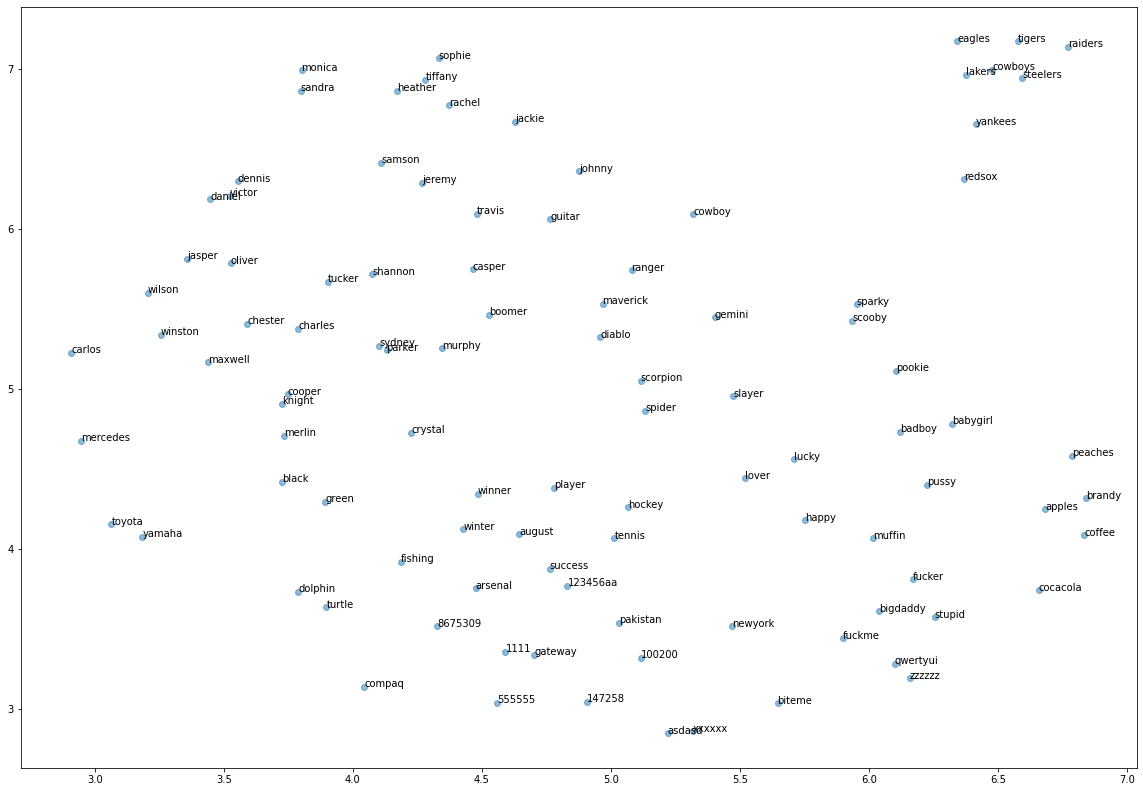

In [98]:
plt.figure(figsize=(20,14))
visualize(viz_scaled,2)

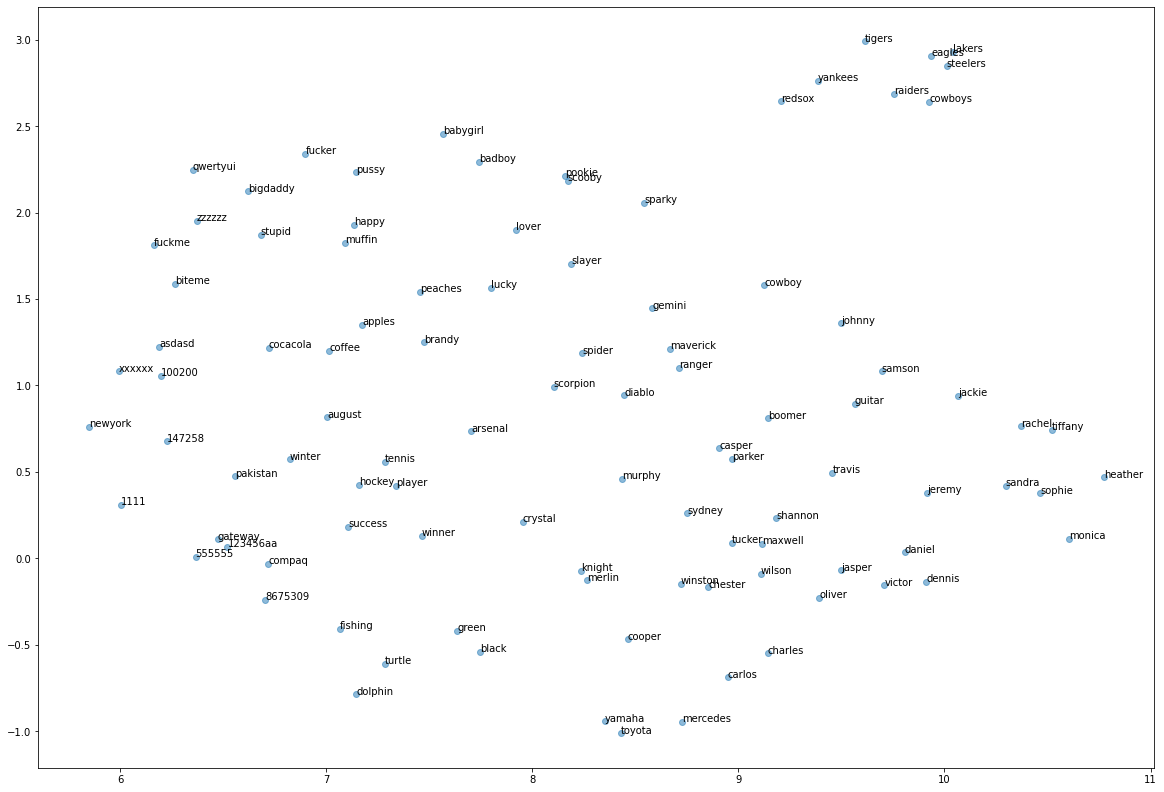

In [100]:
plt.figure(figsize=(20,14))
visualize(viz,2)

In this case, there doesn't seem to be a huge difference from stardardization, most likely because the means and variances are quite uniform. We do see several clusters of related passwords. To characterize this quantitatively, let us try going with k-means. 

### Topic modelling via Clustering

In [101]:
from sklearn.cluster import KMeans
%matplotlib qt

In [273]:
# kmeans object with 12 centroids, experiment with different numbers
kmean = KMeans(n_clusters = 26, n_init=20, init='random')
X = emb.iloc[:2000,:]
kmean.fit(X)

KMeans(init='random', n_clusters=26, n_init=20)

Fitting the kmeans give us 26 centroids. Let us look up closest vector in the dictionary. 

In [274]:
for centroid in kmean.cluster_centers_:
    print(model.similar_by_vector(centroid, topn=2), '\n')

[('porno', 0.8257601261138916), ('porn', 0.809891402721405)] 

[('cuddlepuss', 0.7754456400871277), ('sneezy', 0.7688465714454651)] 

[('siqaya', 0.7663593888282776), ('pambihirang', 0.7647205591201782)] 

[('bitch', 0.789703369140625), ('fucky', 0.7704341411590576)] 

[('davémon', 0.4232199490070343), ('cinémonde', 0.3940982222557068)] 

[('purple', 0.7361342310905457), ('gold/orange', 0.7238848209381104)] 

[('وفي', 0.6468185782432556), ('earlianum', 0.6323521733283997)] 

[('hawkins', 0.7489564418792725), ('mckelton', 0.7464723587036133)] 

[('christ', 0.8448336124420166), ('jesus', 0.8337882161140442)] 

[('vladimov', 0.8321366906166077), ('andrei', 0.8187184929847717)] 

[('miguelángel', 0.8247860074043274), ('migueles', 0.8107373118400574)] 

[('$password', 0.7980891466140747), ('mypassword', 0.7940809726715088)] 

[('⁃', 0.6659188270568848), ('提舉司', 0.6500316262245178)] 

[('no»', 0.5821187496185303), ('@ryan', 0.5774186253547668)] 

[('toyota', 0.7897970676422119), ('roadster',

In [251]:
# use reducer.transform on centroids after fit_transform on X

# def vis_kmeans(X,n,kmean):
#     # umap object
#     reducer = umap.UMAP(n_components=n)
#     idx = X.index
#     X = reducer.fit_transform(X)
#     X = pd.DataFrame(X,index=idx)
    
#     # adding the centroids
#     centroids = pd.DataFrame(kmean.cluster_centers_)
#     cluster_idx = [model.similar_by_vector(c,topn=1)[0][0] for c in kmean.cluster_centers_] 
#     centroids = pd.DataFrame(reducer.transform(centroids),index=cluster_idx)

#     if n==2:
#         # plotting the points
#         plt.scatter(X.iloc[:,0],X.iloc[:,1],alpha=0.5)
#         for i, txt in enumerate(X.index):
#             plt.annotate(txt, (X.iloc[i,0], X.iloc[i,1]))
#         # plotting centroids, labelled by closest point in dictionay
#         plt.scatter(centroids.iloc[:,0],centroids.iloc[:,1], s=200, c='r', marker='s')
#         for i, txt in enumerate(centroids.index):
#             plt.annotate(txt, (centroids.iloc[i,0], centroids.iloc[i,1]))
        
#     if n==3:
#         X.columns=['x','y','z']
    
#         fig=plt.figure(figsize=(15,10))
#         ax = fig.add_subplot(111, projection='3d')
#         ax.scatter(X['x'], X['y'], X['z'])
#         ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
#                yticklabels=[], zticklabels=[])
#         for label, row in X.iterrows():
#             x, y, z = row
#             ax.text(x, y, z, s=label)
#     plt.show()
#     return

In [262]:
def vis_kmeans(X,n,kmean):
    # umap object
    reducer = umap.UMAP(n_components=n)
    
    # adding the centroids
    cluster_idx = [model.similar_by_vector(c,topn=1)[0][0] for c in kmean.cluster_centers_]
    centroids = pd.DataFrame(kmean.cluster_centers_, index=cluster_idx)
    
    X = pd.concat([centroids,X], axis=0)
    k = len(centroids)
    
    idx = X.index
    X = reducer.fit_transform(X)
    X = pd.DataFrame(X,index=idx)
    
    if n==2:
        # plotting the points
        plt.scatter(X.iloc[:k,0],X.iloc[:k,1], s=200, c='r', marker='s')
        plt.scatter(X.iloc[k:,0],X.iloc[k:,1],alpha=0.5)
        
        for i, txt in enumerate(X.index):
            plt.annotate(txt, (X.iloc[i,0], X.iloc[i,1]))
        # plotting centroids, labelled by closest point in dictionay
#         plt.scatter(centroids.iloc[:,0],centroids.iloc[:,1], s=200, c='r', marker='s')
#         for i, txt in enumerate(centroids.index):
#             plt.annotate(txt, (centroids.iloc[i,0], centroids.iloc[i,1]))
        
    if n==3:
        X.columns=['x','y','z']
    
        fig=plt.figure(figsize=(15,10))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X['x'], X['y'], X['z'])
        ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
               yticklabels=[], zticklabels=[])
        for label, row in X.iterrows():
            x, y, z = row
            ax.text(x, y, z, s=label)
    plt.show()
    return

In [275]:
vis_kmeans(X,2,kmean)

In [276]:
X_clusters = 

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
password,,,,,,,,,,,,,,,,,,,,,
123456,0.085685,-0.016403,0.262378,-0.107177,-0.042068,-0.130793,0.256913,-0.405635,0.066068,0.064177,...,-0.418605,0.210022,0.277876,-0.458475,0.006005,0.060775,0.061683,0.188673,0.146644,0.022421
123456789,-0.130535,0.068342,-0.033046,-0.054806,-0.170985,-0.065777,0.07449,-0.504951,-0.024171,0.082977,...,-0.263262,0.124102,0.025722,-0.242219,-0.065629,-0.118434,0.019818,0.197971,-0.08601,0.218956
qwerty,-0.031566,0.385277,-0.021763,-0.158742,-0.056417,-0.410767,-0.074155,0.140993,-0.004023,-0.354872,...,0.035786,-0.100373,0.122964,-0.317977,0.2453,-0.303113,-0.169563,0.180374,0.180517,0.329809
password,-0.028614,0.364398,0.130883,0.084824,-0.198433,-0.259452,0.128979,0.207979,-0.242296,-0.024767,...,-0.023839,-0.223112,-0.006987,-0.489869,0.150709,0.126917,-0.65894,0.299658,0.263977,0.469383
12345,0.116955,0.016777,0.212105,0.021843,-0.304988,-0.005762,0.063454,-0.609076,0.212839,0.097452,...,-0.267434,0.035151,0.29801,-0.407719,-0.0522,0.087453,-0.025644,0.120497,0.060088,-0.024097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
philip,-0.260256,0.164665,-0.218105,-0.033906,-0.376774,0.029613,0.224515,-0.251998,0.088657,0.363574,...,-0.150652,-0.208709,0.001587,0.240083,0.092245,-0.214791,0.001781,0.173762,0.302915,0.010785
kennedy,0.031011,-0.133222,0.046441,-0.07131,0.206476,-0.20231,-0.076582,-0.115647,0.006779,-0.0061,...,-0.191056,0.002792,0.016806,-0.34938,0.073385,-0.280258,0.070238,0.221388,-0.087664,-0.190194
michae,-0.082482,-0.088427,-0.010846,-0.08427,-0.294682,-0.017822,0.376926,-0.071597,0.309389,0.106768,...,-0.415658,-0.702237,0.210574,0.387685,0.10832,-0.02249,0.250303,0.141565,0.262635,0.104392


### Visualization with Plotly

In [269]:
df.iloc[1000:2000,:].tail(60)

,password,frequency,distance_score,passlength,unique_c,first_char,last_char,number_of_uppercase,number_of_digits,number_of_symbols,number_of_lowercase,category,zxcvbn
1940,love11,139,2.01,6,5,lower,digit,0,2,0,4,mixed,1
1941,eclipse,139,3.50,7,6,lower,lower,0,0,0,7,alphabetic,0
1942,joanna,139,4.10,6,4,lower,lower,0,0,0,6,alphabetic,0
1943,1password,139,4.07,9,8,digit,lower,0,1,0,8,alphabetic,1
1944,shadow123,139,3.39,9,9,lower,digit,0,3,0,6,mixed,1
1945,zaq1xsw2,139,1.40,8,8,lower,digit,0,2,0,6,others,1
1946,hamster,139,3.72,7,7,lower,lower,0,0,0,7,alphabetic,1
1947,asakapa,139,5.69,7,4,lower,lower,0,0,0,7,alphabetic,2
1948,lonely,139,3.49,6,5,lower,lower,0,0,0,6,alphabetic,1
1949,austin1,139,4.20,7,7,lower,digit,0,1,0,6,alphabetic,1
